# ДЗ1 - имитационное обучение
Крайний срок сдачи - 20.02.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: смотреть, что такое клонирование поведеня и разобраться с алгоритмом DAgger.
Вместо человека-демонстранта демонстрации будут даваться специальной предобученной "экспертной" стартегией. Ваша задача будет заключаться в реализации алгоритма клонирования и DAgger, сравнения их произвоодительости на нескольких простых задачах управления из пакета OpenAI Gym. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/uNq18mDY284JdI7o5KgJ) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

__Будьте винимательны!__ В заготовках кода ниже могут быть неточности! Их правка входит в задачу выполнения ДЗ! Как минимум, вам нужно дописывать строчик кода ниже пометок __Ваш код здесь__.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__<br>
Будем использовать набор симуляционных сред MuJoCo.  Загружайте версию 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа можно испоьзовать ваше университетский аккаунт -  https://www.roboti.us/license.html.
***

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version : 1.10.0
Gym version : 0.10.9


***
## Сборием статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [2]:
#choose environment (Uncomment choosed one)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

# choose expert policy file from /expert file
expert_policy_file="experts/"+env_name+".pkl"

# load the policy
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

# make the environment
env = gym.make(env_name)

# function to generate rollouts from the expert policies 
def generate_rollouts(num_rollouts,max_steps,render=False):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            #number of iteration (episode)
            #print('iter', i)
            # parameters to initial values
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action = policy_fn(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        
        # print the reward information
        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [3]:
generate_rollouts(num_rollouts=4,max_steps=400,render=True);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw
returns [3843.9711847766057, 3807.6875412586596, 3713.2955085228273, 3846.8636918030275]
mean return 3802.95448159028
std of return 54.01740920091651


***
## 1. Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью когорого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

Кроме конструктора, вам нужно дореализовать метод __train__ класса __BC_Model__:

In [8]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
        #                        size of window         movement of window
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [19]:
from sklearn.utils import shuffle
from tensorflow.contrib import rnn
class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64):
        tf.reset_default_graph()                
        # define tensorflow session
        self.sess = tf.Session()
        #tf.reset_default_graph()        

        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        ### Ваш код здесь - нужно добавить функцию потерь l2_loss ###
        # self.loss = tf...
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)

    def build_model(self, input_placeholder):
        # build the neural network  (you can try another architecture)
        ### Ваш код здесь - нужно реализовать свою архитектуру ###
        # x= tf.layers....
        #tf.reset_default_graph()
        n_nodes_hl1 = 500
        n_nodes_hl2 = 500
        n_nodes_hl3 = 500

        n_classes = 17
        batch_size = 64

        #x = tf.placeholder('float', [None, 784])
        x = self.input_placeholder
        #y = tf.placeholder('float')
        keep_rate = 0.8
        keep_prob = tf.placeholder(tf.float32)
        weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,1,32])),
                   'W_conv2':tf.Variable(tf.random_normal([5,5,32,64])),
                   'W_fc':tf.Variable(tf.random_normal([7*7*64,1024])),
                   'out':tf.Variable(tf.random_normal([1024, n_classes]))}

        biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
                   'b_conv2':tf.Variable(tf.random_normal([64])),
                   'b_fc':tf.Variable(tf.random_normal([1024])),
                   'out':tf.Variable(tf.random_normal([n_classes]))}

        x = tf.reshape(x, shape=[-1, self.input_shape[0], self.input_shape[1], 1])

        conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
        conv1 = maxpool2d(conv1)

        conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
        conv2 = maxpool2d(conv2)

        fc = tf.reshape(conv2,[-1, 7*7*64])
        fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
        fc = tf.nn.dropout(fc, keep_rate)

        output = tf.matmul(fc, weights['out'])+biases['out']

        return output       
#return outputs

    def train(self, epochs = 200, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        #tf.reset_default_graph()
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                #tf.get_default_graph().get_tensor_by_name(self.output_placeholder_model)
                self.sess.run([optimizer, self.output_placeholder_model], feed_dict = feed_train)
                #_, l, predictions = self.sess.run([optimizer, self.loss, self.output_placeholder_model], feed_dict = feed_train)
                #print(l)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

## trying to make an lstm

In [ ]:
        num_input = 376 # MNIST data input (img shape: 28*28)
        timesteps = 28 # timesteps
        num_hidden = 128 # hidden layer num of features
        num_classes = 17 # MNIST total classes (0-9 digits)

# tf Graph input
        X = tf.placeholder("float", [None, timesteps, num_input])
        Y = tf.placeholder("float", [None, num_classes])

# Define weights
        weights = {
            'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
        }
        biases = {
            'out': tf.Variable(tf.random_normal([num_classes]))
        }


#def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
        x = tf.unstack(X, timesteps, 1)
    
    # Define a lstm cell with tensorflow
        lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
        logits = tf.matmul(outputs[-1], weights['out']) + biases['out']

       # logits 
        prediction = tf.nn.softmax(logits)

# Define loss and optimizer
        loss_op = tf.nn.l2_loss(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=Y))
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        #train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
        #init = tf.global_variables_initializer()
        return outputs


## trying to make a simple mlp

In [ ]:
        n_hidden_1 = 128 # 1st layer number of neurons
        n_hidden_2 = 128 # 2nd layer number of neurons
        num_input = 376 
        num_classes = 17 
        weights = {
            'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])), #, dtype=tf.float64
            'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'out': tf.Variable(tf.random_normal([num_classes]))
        }
               # Hidden fully connected layer with 256 neurons
        #x = tf.cast(x, tf.float32)
        ###input_placeholder = tf.cast(input_placeholder, tf.float32)
        ###layer_1 = tf.add(tf.matmul(input_placeholder, weights['h1']), biases['b1'])
        #Hidden fully connected layer with 256 neurons
        ###layer_1 = tf.cast(layer_1, tf.float32)
        ###layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        # Output fully connected layer with a neuron for each class
        ###out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
        #W = tf.Variable(tf.random_uniform([376, 64], 0, 0.01))
        #out_placeholder_model = tf.matmul(input_placeholder, W)
        layer_1 = tf.add(tf.matmul(input_placeholder, weights['h1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        #layer_1 = tf.nn.dropout(layer_1, 0.25)
        layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        #layer_2 = tf.nn.dropout(layer_2, 0.25)

        #layer_1 = tf.nn.dropout(layer_1, keep_prob)
        out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
        #out_placeholder_model = tf.layers.dense(inputs=out_placeholder_model, units=17, activation=tf.nn.relu)
        #loss = tf.nn.l2_loss(out_placeholder_model)        


### Обучем модель на экспертных данных

In [4]:
# generate expert data
data=generate_rollouts(num_rollouts=5,max_steps=100,render=True);
x = data['observations']
y = data['actions']
print ('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)



Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw
returns [644.4550234462138, 646.2445097770599, 639.293789943844, 644.2479546217577, 659.7014478056071]
mean return 646.7885451188965
std of return 6.857263431641435
dimension of obs : (500, 376)
dimension of actions : (500, 1, 17)


In [20]:
# shuffle data
x,y = shuffle(x,y)

# create an object from BC_Model class, and train it
cloner=BC_Model(x,y)
print(cloner.batch_size)
print(cloner.input_data.shape)
cloner.train()

ValueError: Dimension size must be evenly divisible by 3136 but is 96256 for 'Reshape_1' (op: 'Reshape') with input shapes: [1,16,94,64], [2] and with input tensors computed as partial shapes: input[1] = [?,3136].

In [10]:
#from 25451213000.0 to 932890.7

Tensor("L2Loss:0", shape=(), dtype=float32)


### Испытываем модель

In [21]:
num_eval_rollouts=100
# loop over runouts
returns=[]
#totalr = 0
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        totalr+=r
        #if render == True:
        env.render()
    returns.append(totalr)
print(returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))


[78.40317552437696, 84.02719095187153, 94.4677385011751, 100.53352647666432, 80.36763227997048, 136.88796166329502, 103.85728169007291, 168.8122481164002, 78.57987093100606, 88.6454975992719, 78.91222461787967, 88.86797862798551, 107.43926607846785, 84.5815780527388, 113.24598330792172, 105.193399045507, 96.97422511218517, 131.94266374028143, 85.1195210237275, 92.45121325030982, 224.3147053154392, 89.41632284043854, 130.11418590434587, 85.66299029410679, 160.70574678166918, 106.84117629882155, 118.41511217833606, 90.01550702526612, 127.12645943997656, 87.85610490389284, 93.28748909919197, 145.02813121320824, 130.02253714060888, 86.41541649778239, 94.37642521562397, 132.85147568863118, 179.75809093259792, 89.23906821747262, 96.69715852876816, 75.28684874692958, 112.05321741152775, 104.68929255735945, 86.65851958456008, 113.5527823120745, 79.63456935898577, 93.85637552268885, 147.36740258094792, 89.80995011092882, 88.35340892247655, 89.5160104343571, 162.557642939849, 85.17683846775296, 

In [25]:
def generate_eval_rollouts(num_rollouts,max_steps,render=False):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            #number of iteration (episode)
            #print('iter', i)
            # parameters to initial values
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action=cloner.sample(obs)
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render == True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        
        # print the reward information
        #print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data, totalr

In [26]:
generate_eval_rollouts(100,100,render=True)

mean return 117.01804042466111
std of return 39.34010619447041


({'observations': array([[ 1.40929949e+00,  9.99978949e-01, -1.72931325e-03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.40736043e+00,  9.99560047e-01,  1.01749239e-03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.40116160e+00,  9.98112920e-01,  8.28881484e-04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 1.05022618e+00,  9.85447981e-01,  1.56652514e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.02337633e+00,  9.84774250e-01,  1.52736547e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.00433487e+00,  9.84933873e-01,  1.37623945e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
  'actions': array([[-3.9612489e+00, -1.3394644e+00, -8.3105450e+00, ...,
           2.9425142e+00, -3.0926723e+00,  1.1976047e+00],
         [ 2.9288916e+01, -6.4309090e+01,  1.1183698e+02, ...,
    

mean return 138.23343435725315
std of return 64.01891770634363
mean return 114.27617212069444
std of return 36.9763500905697
mean return 117.34893427975364
std of return 39.735514883198924
mean return 119.38760163380233
std of return 44.34371269397573
mean return 114.41931182540031
std of return 35.05989731038525
mean return 116.09066972065818
std of return 36.524378195656936
mean return 111.11186944131833
std of return 35.882784080974126
mean return 118.7697296007147
std of return 41.4305463414085
mean return 118.21369231831011
std of return 42.54309412664493


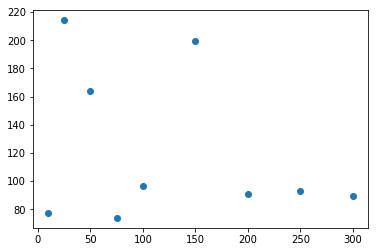

In [29]:
different_rollouts=[10, 25, 50, 75, 100, 150, 200, 250, 300]
d={}
for r in different_rollouts:
    d[r] = generate_eval_rollouts(r, 100, render=True)[1]
import matplotlib.pyplot as plt
plt.scatter(d.keys(), d.values())
plt.show()

In [28]:
print(d)

{10: ({'observations': array([[ 1.40407187,  0.99995135,  0.00974743, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.40217132,  0.9996303 ,  0.01239585, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.39603325,  0.99835189,  0.01206059, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.10280701,  0.98692264, -0.15698957, ..., -1.16213185,
         4.62233649,  5.10291799],
       [ 1.06657913,  0.98364696, -0.1747132 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.02873859,  0.98102511, -0.1893139 , ...,  0.        ,
         0.        ,  0.        ]]), 'actions': array([[-3.64687395e+00, -6.74803019e-01, -9.09231091e+00, ...,
         3.34894824e+00, -4.22546387e+00,  1.20359373e+00],
       [ 2.94591885e+01, -6.99882050e+01,  1.15044052e+02, ...,
         6.20499496e+01, -1.35870733e+01, -2.35124893e+02],
       [-7.40429916e+01,  8.65465775e+01,  2.78625202e+01, ...,
        -1.36262693e+01, -2.72390442e+01

__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MoJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

In [ ]:
#model #2

In [ ]:
#model #3

In [ ]:
#графики отдачи:

__Задание 1.2.__ Выберите один из гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте график влияния значения этого параметра на качество обучения (totalr).

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

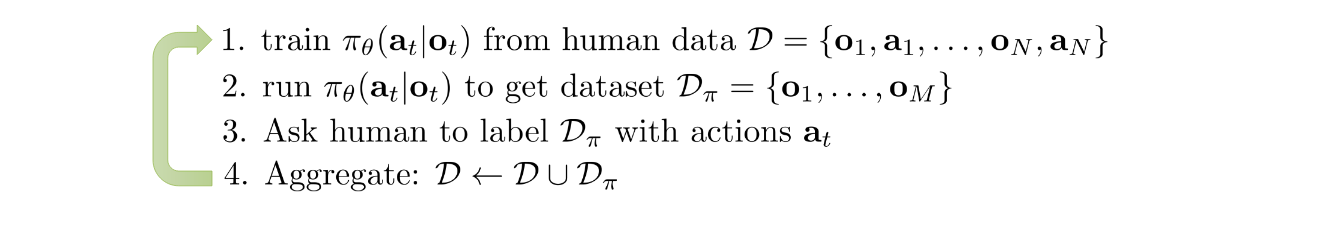

In [ ]:
with tf.Session():
    DAgger_iter=30
    render=False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            # get an action from the model
            ### Ваш код здесь - испольузуем оубченную модель ###
            # action = ...
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            # get the expert action for the same input
            ### Ваш код здесь - испольузуем olicy_fn!! ###
            # corrected_action = 
            
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        # train the model on the collected data
        ### Ваш код здесь - дообучаем модель ###
        #cloner.train...
        

### Проверяем работу

In [ ]:
num_eval_rollouts=20
# loop over runouts
returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

__Задание 2.1.__ Проверьте работу DAagger на всех задачах MoJoCo - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.